In [ ]:
import os 
import cv2
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import drive
drive. mount("/content/drive")
data_root_path = '/content/drive/MyDrive/Demo/archive/'
test_folder = data_root_path + 'test_set/test_set/'
train_folder = data_root_path + 'training_set/training_set/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


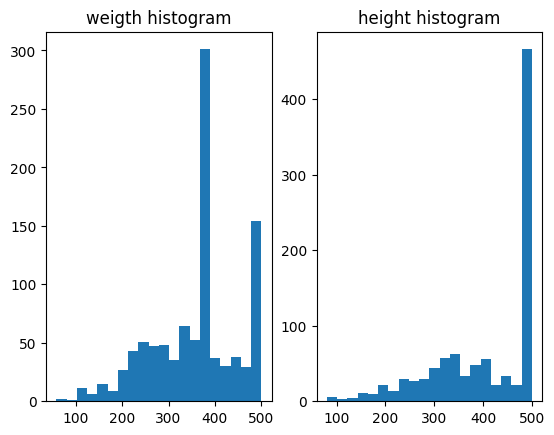

In [ ]:
considered_folder = train_folder + 'cats/'
list_cat_test_image = os.listdir(considered_folder)

weigth_list = []
height_list = []

for image_name in list_cat_test_image[0:1000]:
  image_path = considered_folder + image_name
  image = cv2.imread(image_path)
  weigth_list.append(image.shape[0])
  height_list.append(image.shape[1])

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].hist(weigth_list, bins=20) 
axes[0].set_title('weigth histogram')
axes[1].hist(height_list, bins=20) 
axes[1].set_title('height histogram')
plt.show()

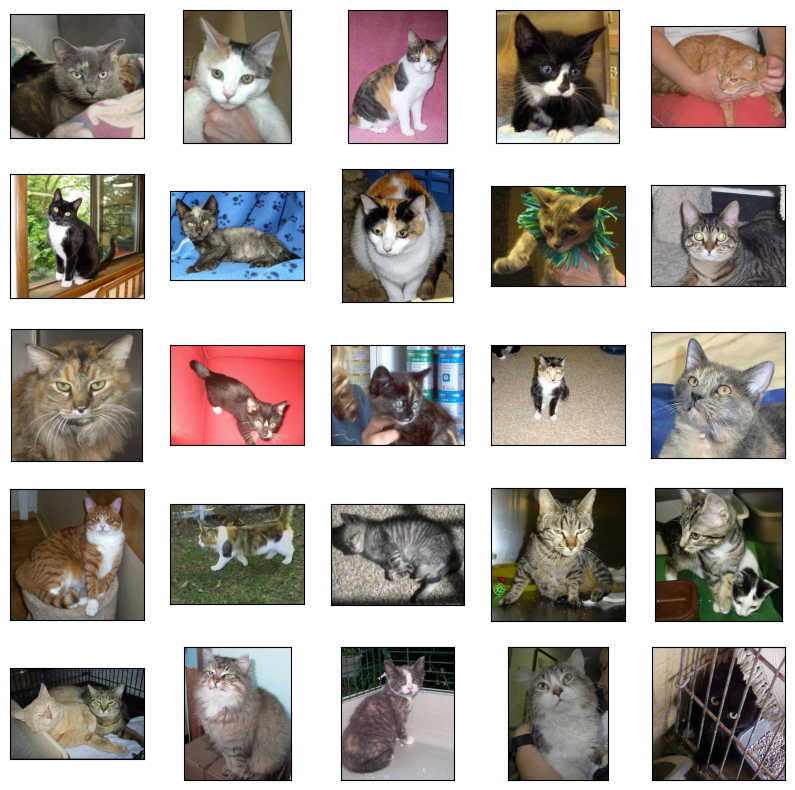

In [ ]:
considered_folder = train_folder + 'cats/'
list_cat_test_image = os.listdir(considered_folder)
random_index = np.random.randint(low=0, high=len(list_cat_test_image), size=25)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
for index, ax in enumerate(axes.flat):
  image_path = considered_folder + list_cat_test_image[random_index[index]]
  current_image = cv2.imread(image_path)
  RGB_img = cv2.cvtColor(current_image, cv2.COLOR_BGR2RGB)
  ax.imshow(RGB_img)

plt.show()

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)

In [ ]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

train_images = train_generator.flow_from_directory(
    directory=train_folder,
    target_size=TARGET_SIZE,
    classes=['cats', 'dogs'],
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=42,
    subset='training',
    interpolation='bicubic',
)

# validate_images = val_generator.flow_from_directory(
#     directory=train_folder,
#     target_size=TARGET_SIZE,
#     classes=['cats', 'dogs'],
#     class_mode='categorical',
#     batch_size=BATCH_SIZE,
#     seed=42,
#     interpolation='bicubic',
# )

test_images = test_generator.flow_from_directory(
    directory=test_folder,
    target_size=TARGET_SIZE,
    classes=['cats', 'dogs'],
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    interpolation='bicubic',
    shuffle=False,
)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [ ]:
augment = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
])

In [ ]:
pretrained_model = tf.keras.applications.xception.Xception(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
inputs = pretrained_model.input
x = augment(inputs)

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dropout(0.45)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.45)(x)


outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    # validation_data=validate_images,
    # validation_steps=len(validate_images),
    epochs=20,
)


Epoch 1/20
251/251 [==============================] - 101s 274ms/step - loss: 0.6436 - accuracy: 0.6922
Epoch 2/20
251/251 [==============================] - 69s 274ms/step - loss: 0.2978 - accuracy: 0.8766
Epoch 3/20
251/251 [==============================] - 67s 267ms/step - loss: 0.1909 - accuracy: 0.9298
Epoch 4/20
251/251 [==============================] - 69s 276ms/step - loss: 0.1486 - accuracy: 0.9504
Epoch 5/20
251/251 [==============================] - 67s 267ms/step - loss: 0.1126 - accuracy: 0.9616
Epoch 6/20
251/251 [==============================] - 66s 263ms/step - loss: 0.0943 - accuracy: 0.9699
Epoch 7/20
251/251 [==============================] - 67s 266ms/step - loss: 0.0839 - accuracy: 0.9723
Epoch 8/20
251/251 [==============================] - 69s 273ms/step - loss: 0.0808 - accuracy: 0.9749
Epoch 9/20
251/251 [==============================] - 66s 262ms/step - loss: 0.0746 - accuracy: 0.9773
Epoch 10/20
251/251 [==============================] - 68s 269ms/step - 

In [ ]:
model.save('/content/drive/MyDrive/Demo/DogCatChecker.h5')

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

# accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(accuracy))
# plt.plot(epochs, accuracy, 'b', label='Training accuracy')
# plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

# plt.title('Training and validation accuracy')
# plt.legend()
# plt.figure()
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')

# plt.title('Training and validation loss')
# plt.legend()
# plt.show()

KeyboardInterrupt: ignored

In [ ]:
# random_index = np.random.randint(0, len(test_df) - 1, 15)
# fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
#                         subplot_kw={'xticks': [], 'yticks': []})

# for i, ax in enumerate(axes.flat):
#     ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
#     if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
#         color = "green"
#     else:
#         color = "red"
#     ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
# plt.show()
# plt.tight_layout()

In [ ]:
class_dict = {0:'cat', 1:'dog'}
y_pred = []
y_true = []
for batchs in test_images:
  X, Y = batchs
  for index, y in enumerate(Y):
    true_class = class_dict[np.argmax(y)]
    y_true.append(true_class)
    image = X[index:index+1]
    predict_class = model.predict(image)
    predict_class = class_dict[np.argmax(predict_class)]
    y_pred.append(predict_class)

# X, Y = test_images.next()
# X[0:1].shape

1/1 [==============================] - 0s 36ms/step


KeyboardInterrupt: ignored

<Axes: >

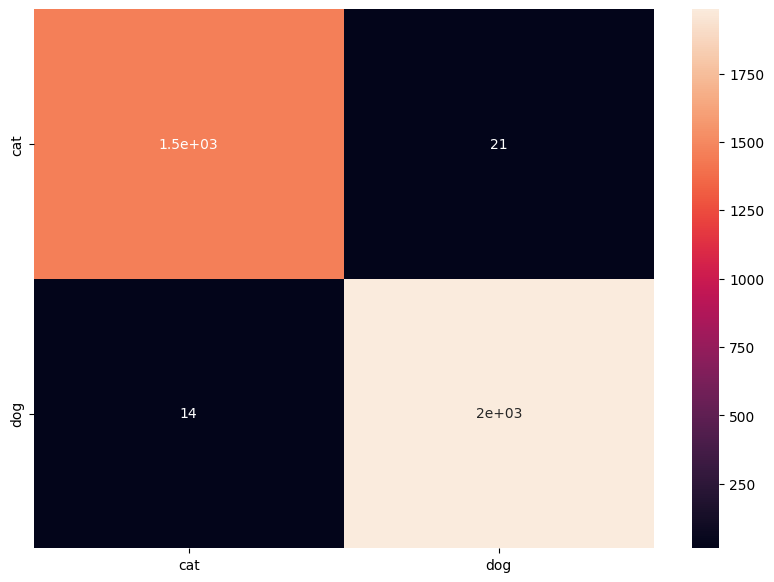

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_true[0:-1], y_pred, labels=['cat', 'dog'])

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(matrix, index = ['cat', 'dog'],
                  columns = ['cat', 'dog'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

Read 1 image demo

(416, 416, 3)


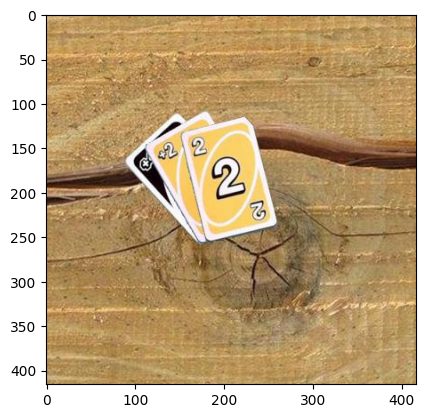

In [ ]:
data_root_path = '/content/drive/MyDrive/Demo/Uno Cards.v2-raw.retinanet/'
demo_image_path = data_root_path + 'train/000244709_jpg.rf.a229d38b2da3011f011866b6e0d7806c.jpg'
csv_path = data_root_path + 'train/_annotations.csv'
image = cv2.imread(demo_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
anotaion_file = pd.read_csv(csv_path)
anotation_infor = {}

for index, row in anotaion_file.iterrows():
  class Object:
    def __init__(self, bounding_box, class_number):
      self.bounding_box = bounding_box
      self.class_number = class_number
  image_name = row[0]
  bounding_box = row[1:5].to_list()
  class_number = row[-1]
  current_object = Object(bounding_box, class_number)
  if image_name in anotation_infor.keys():
    anotation_infor[image_name].append(current_object)
  else:
    anotation_infor[image_name] = []
    anotation_infor[image_name].append(current_object)




print(image.shape)
plt.imshow(image)
plt.show()

3


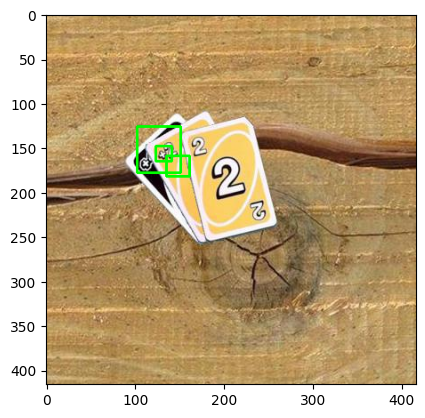

In [ ]:
image = cv2.imread(demo_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
for current_object in anotation_infor['000244709_jpg.rf.a229d38b2da3011f011866b6e0d7806c.jpg']:
  cv2.rectangle(image, (current_object.bounding_box[0], current_object.bounding_box[2]), (current_object.bounding_box[1], current_object.bounding_box[3]), color = [0, 255, 0], thickness = 2)

print(len(anotation_infor['000244709_jpg.rf.a229d38b2da3011f011866b6e0d7806c.jpg']))
plt.imshow(image)
plt.show()

(800, 800, 3)


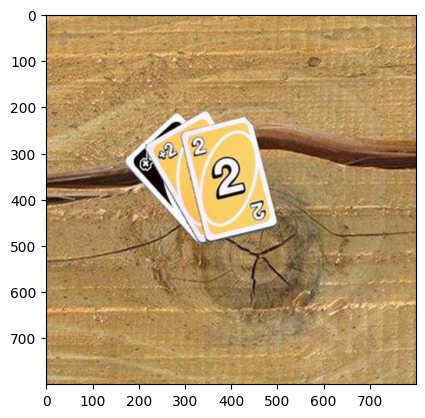

In [ ]:
image = cv2.resize(image, dsize=(800, 800), interpolation = cv2.INTER_CUBIC)

print(image.shape)
plt.imshow(image)
plt.show()

In [ ]:
weigth_ratio = 800 / image.shape[1]
height_ratio = 800 / image.shape[0]


In [ ]:
input_layer = tf.keras.Input(
    shape=(800, 800, 3),
    batch_size=None,
    name=None,
    dtype=None,
    sparse=None,
    tensor=None,
    ragged=None,
    type_spec=None,
)

model = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=input_layer,
    input_shape=None,
    pooling=None,
)



58889256/58889256 [==============================] - 0s 0us/step


(800, 800, 3)


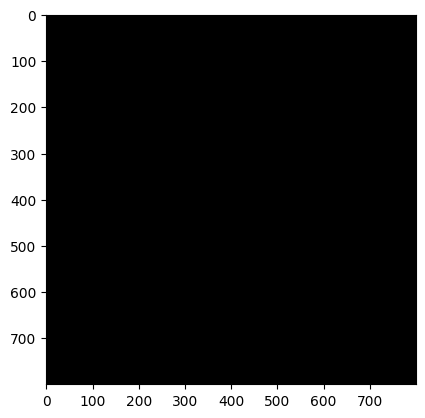

(1, 25, 25, 512)
(1, 25, 25, 512)


In [ ]:
dummy_image = tf.zeros((1, 800, 800, 3), dtype=tf.dtypes.float32)

print(dummy_image[0].shape)
plt.imshow(dummy_image[0])
plt.show()

output = model(dummy_image)
print(output.shape)


output = model((np.expand_dims(image,0)))
print(output.shape)


In [ ]:
fe_size = (800//32)
ctr_x = np.arange(32, (fe_size + 1) * 32, 32) # start, stop, step
ctr_y = np.arange(32, (fe_size + 1) * 16, 32)

print(fe_size)
print(ctr_x)
print(len(ctr_x))

25
[ 32  64  96 128 160 192 224 256 288 320 352 384 416 448 480 512 544 576
 608 640 672 704 736 768 800]
25


In [ ]:
index = 0
ctr = np.zeros((625, 2))
for x in range(len(ctr_x)):
  for y in range(len(ctr_y)):
    ctr[index, 1] = ctr_x[x] - 8
    ctr[index, 0] = ctr_y[y] - 8
    index = index + 1

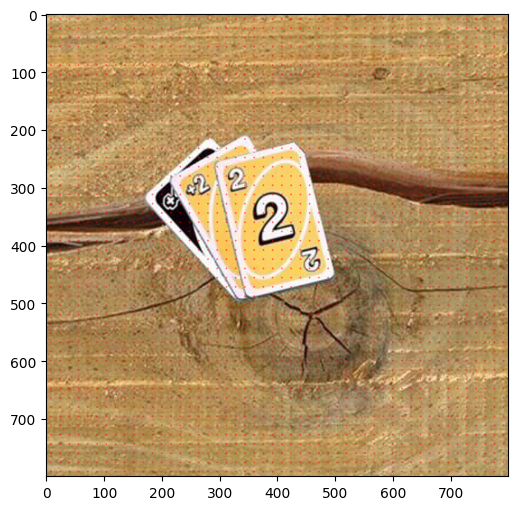

In [ ]:
plt.figure(figsize=(9,6))
for i in range(ctr.shape[0]):
  cv2.circle(image, (int(ctr[i][0]), int( ctr[i][1] )), radius = 1, color = (255, 0, 0), thickness = 1 )
plt.imshow(image)
plt.show()

In [ ]:
ratios = [0.5, 1, 2]
scales = [8, 6, 12]
sub_sample = 32
anchor_boxes = np.zeros( (fe_size ** 2 * 9, 4) )
index = 0

for c in ctr:
  ctr_y, ctr_x = c
  for i in range(len(ratios)):
    for j in range(len(scales)):
      h = sub_sample * scales[j] * np.sqrt(ratios[i])
      w = sub_sample * scales[j] * np.sqrt(1./ratios[i])
      anchor_boxes[index, 0] = ctr_y - h / 2.0
      anchor_boxes[index, 1] = ctr_x - w / 2.0
      anchor_boxes[index, 2] = ctr_y + h / 2.0
      anchor_boxes[index, 3] = ctr_x + w / 2.0
      index = index + 1

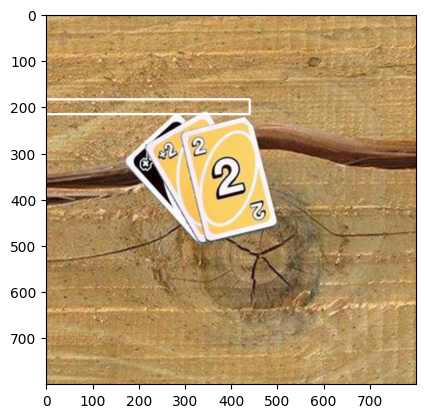

In [ ]:
x0, y0, x1, y1 = [anchor_boxes[300, 1], anchor_boxes[300, 0], anchor_boxes[300, 2], anchor_boxes[300, 3]]
cv2.rectangle(image, (int(x0), int(y0)), (int(x1), int(y1)), color = [255, 255, 255], thickness = 3)
plt.imshow(image)
plt.show()

In [ ]:
index_inside = np.where(
    (anchor_boxes[:, 0] >= 0) &
    (anchor_boxes[:, 1] >= 0) & 
    (anchor_boxes[:, 2] <= 800) &
    (anchor_boxes[:, 3] <= 800)
)[0]

valid_anchor_box = anchor_boxes[index_inside  ]





